In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics import average_precision_score
from aerosonicdb.utils import get_project_root, load_test_data, load_flatten_test_data
from aerosonicdb.features import extract_env_mfccs as extract
tf.get_logger().setLevel('ERROR')

In [2]:
ROOT_PATH = get_project_root()
EVAL_FEAT_PATH = os.path.join(ROOT_PATH, 'data/processed')
ENV_FEAT_BASE = '_ENV_13_mfcc_5.json'
OUTPUT_PATH = os.path.join(ROOT_PATH, 'models')
ALL_ENV_FEAT_PATH = os.path.join(EVAL_FEAT_PATH, 'all_env')

In [3]:
extract.extract_all_env_feats(output_path=ALL_ENV_FEAT_PATH, ignore=False)

MFCCs extracted.


In [4]:
def load_env_data(env_n, env_base=ENV_FEAT_BASE, feat_path=EVAL_FEAT_PATH):
    
    env_path = f'{env_n}{env_base}'
    env_path = os.path.join(feat_path, env_path)
    
    X, y = load_test_data(data_path=env_path, target_label='class_label', print_msg=False)
    
    return X, y

In [5]:
def load_keras_model(short_model_name: str, root=ROOT_PATH):
    
    full_path = os.path.join(root, 'models', short_model_name, 'model')
    
    return tf.keras.models.load_model(full_path)

In [6]:
def load_lr_model(short_model_name: str, root=ROOT_PATH):
    
    model_path = f'{short_model_name}.sav'
    full_path = os.path.join(root, 'models', model_path)
    
    return pickle.load(open(full_path, 'rb'))

In [7]:
def evaluate_models():
    res_dict = {}
    for m in ['lr', 'mlp', 'cnn']:
        
        res_dict[m] = {}
        
        for i in range(1, 6):
            
            res_dict[m][i] = []
            
            model_name = f'{m}_{i}'            
            
            if m in ['mlp', 'cnn']:
                model = load_keras_model(short_model_name=model_name)
                
            elif m == 'lr':
                model = load_lr_model(short_model_name=model_name)
            
            for j in range(1, 7):
            
                X, y = load_env_data(env_n=j)
                
                if m in ['mlp', 'cnn']:
                
                    y_prob = model.predict(X, batch_size=216, verbose=0)
                    
                elif m == 'lr':
                    
                    # flatten MFCC array
                    nsamples, nx, ny = X.shape
                    X = X.reshape((nsamples, nx * ny))
                    y_prob = model.predict_proba(X)[:, 1]
                
                results = average_precision_score(y, y_prob)
                
                mod_env = f'{model_name.upper()}_{j}'
                res_dict[m][i].append(results)


    reformed_dict = {}
    for outerKey, innerDict in res_dict.items():
        for innerKey, values in innerDict.items():
            reformed_dict[(outerKey,
                           innerKey)] = values
            
    df = pd.DataFrame(reformed_dict)
    df = df.set_index(pd.Index([1, 2, 3, 4, 5, 6]))
    df.index.name = 'Env Hour'
    df['Mean'] = df.mean(axis=1)
    df.loc['Mean', :] = df.mean(axis=0)
    
    return df

In [8]:
results = evaluate_models()

In [9]:
idx = pd.IndexSlice
slice_ = idx['Mean', :]
(results.style.highlight_min(subset='Mean', color='red')).highlight_min(subset=slice_, color='red', axis=1).highlight_max(subset='Mean', color='yellow').highlight_max(subset=slice_, color='yellow', axis=1)

In [10]:
# print(results.style.format(precision=3).to_latex())

### Plot Environment Predictions

In [11]:
def fetch_ignore_indices(env_n):
    
    df = pd.read_csv('../data/raw/environment_class_mappings.csv')
    
    arr = df[str(env_n-1)]
    
    ignore_list = []
    for i in arr.index:
        if arr.iloc[i] == 'ignore':
            ignore_list.append(i)
        else:
            pass

    lst = []
    fst = []
    for i in range(0, len(ignore_list)):

        if i == 0:
            first = ignore_list[i]
            fst.append(first)

        elif i == len(ignore_list)-1:
            last = ignore_list[-1]
            lst.append(last)

        else:
            if (ignore_list[i]-1 == ignore_list[i-1]) & (ignore_list[i]+1 == ignore_list[i+1]):
                pass

            elif (ignore_list[i]-1 == ignore_list[i-1]) & (ignore_list[i]+1 != ignore_list[i+1]):
                last = ignore_list[i]
                lst.append(last)

            elif (ignore_list[i]-1 != ignore_list[i-1]) & (ignore_list[i]+1 == ignore_list[i+1]):
                first = ignore_list[i]
                fst.append(first)
    
    
    if len(fst) == len(lst):
        
        tupes = []

        for i in range(0, len(fst)):
            tupes.append((fst[i], lst[i]+1))
    
    else:
        print('array length mismatch')
    
    return tupes
    

In [12]:
def plot_env_predictions(short_model_name: str, env_n: str):
    
    title = f'ENV_{env_n}_{short_model_name}'
    
    X, y = load_env_data(env_n=env_n, feat_path=ALL_ENV_FEAT_PATH)
    
    if ('mlp' in short_model_name) | ('cnn' in short_model_name):
        
        model = load_keras_model(short_model_name)

        y_prob = model.predict(X, batch_size=216, verbose=0)
        
    elif 'lr' in short_model_name:
        
        model = load_lr_model(short_model_name=short_model_name)
        
        # flatten MFCC array
        nsamples, nx, ny = X.shape
        X = X.reshape((nsamples, nx * ny))
        y_prob = model.predict_proba(X)[:, 1]
           
    df = pd.read_csv('../data/raw/environment_mappings_raw.csv')
    idx_n = str(int(env_n)-1)
    
    raw = df[idx_n]
    
    dfn = pd.read_csv('../data/raw/environment_class_mappings.csv')
    ig = dfn[idx_n]
    ig = ig.replace('1', '0')
    ig = ig.replace('ignore', '1')
    
    tot_frames = len(y_prob)
    
    sub_frames = int(tot_frames / 1)
    
    start = 0
    
    ig_idx = fetch_ignore_indices(env_n=env_n)
    
    for i in range(0,1):
        end = start + sub_frames
        
        fig = plt.figure(figsize=(8, 3))
        ax = plt.subplot(111)
        
        for tupe in ig_idx:
            if (tupe[0] >= start) & (tupe[1] <= end):
                if i == 0:
                    ax.axvspan(tupe[0], tupe[1], facecolor='gold', alpha=0.25)
                elif i == 1:
                    ax.axvspan((tupe[0]-sub_frames), (tupe[1]-sub_frames), facecolor='gold', alpha=0.25)
        
        
        x_ticks = np.arange(0, (720+1), step=60)
        x_labels = np.arange(start//12, ((end//12)+1), step=5)   
        plt.xticks(x_ticks, x_labels)
        
        gt = ax.plot(range(len(raw[start:end])), raw[start:end], linewidth=1.5, linestyle='dotted', color='seagreen', label='Ground truth')
        thresh = ax.axhline(y=0.5, xmin=-0.05, xmax=1, color='r', linewidth=0.7, alpha=0.5, label='50% threshold')
        pred = ax.plot(range(len(y[start:end])), y_prob[start:end], color='k', linewidth=.25, alpha=0.9)
        ax.fill_between(x=range(len(y[start:end])), y1=y_prob[start:end].flatten(), alpha=0.1, color='k')
        plt.ylim(-0.01,1.1)
        plt.xlabel('Time (minutes)')
        plt.ylabel('Probability')
        patch = Patch(facecolor='gold', alpha=0.25, label='Onset/Outset (ignore)')
        patch2 = Patch(facecolor='k', alpha=0.1, edgecolor=(0.0, 0.0, 0.0, 0.9), label='Model prediction')
        plt.title(f'Model: {short_model_name}, Env: {env_n}')
        
        # Shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.25,
                         box.width, box.height * 0.75])

        # Put a legend below current axis
        ax.legend(handles=[gt[0], thresh, patch2, patch], loc='upper center', bbox_to_anchor=(0.5, -0.25),
                  fancybox=True, shadow=False, ncol=4, prop={'size': 8})
        
        # check for/create output directory for figures
        if not os.path.isdir('../figures'):
            os.mkdir('../figures')
        
        #plt.legend(handles=[gt[0], thresh, pred[0], patch], loc='best')
        plt.savefig(f'../figures/{short_model_name}_env_{env_n}.png', dpi=300)
        plt.show()
        
        start = end
        
        plt.close()
    

## Best Overall Model on Easiest Environment Hour

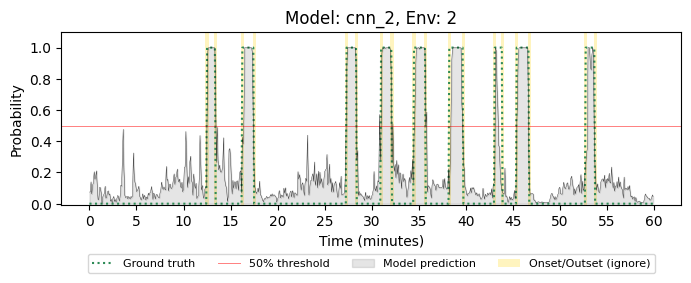

In [13]:
plot_env_predictions(short_model_name='cnn_2', env_n=2)

## Best Overall Model on Hardest Environment Hour

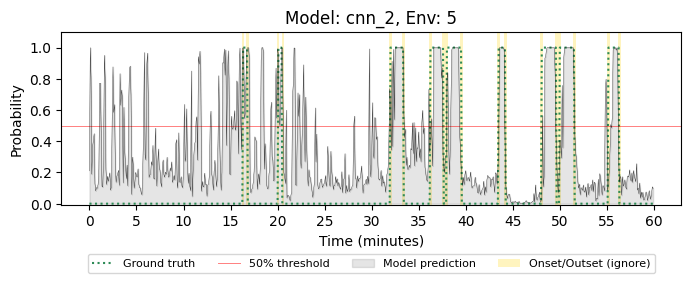

In [14]:
plot_env_predictions(short_model_name='cnn_2', env_n=5)

## Worst Overall Model on Easiest Environment Hour

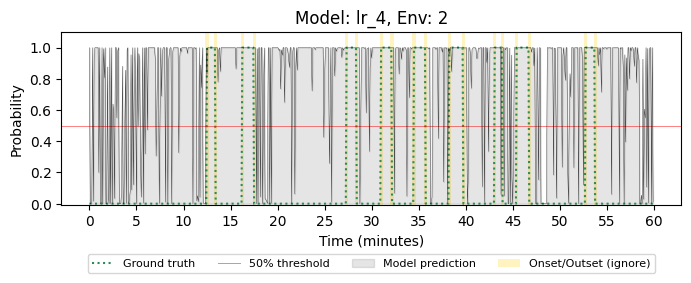

In [15]:
plot_env_predictions(short_model_name='lr_4', env_n=2)

## Worst Overall Model on Hardest Environment Hour

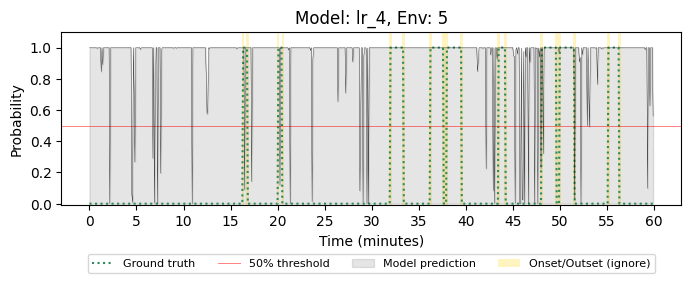

In [16]:
plot_env_predictions(short_model_name='lr_4', env_n=5)

### Comparison of MLP and CNN models with same AP for Env 5

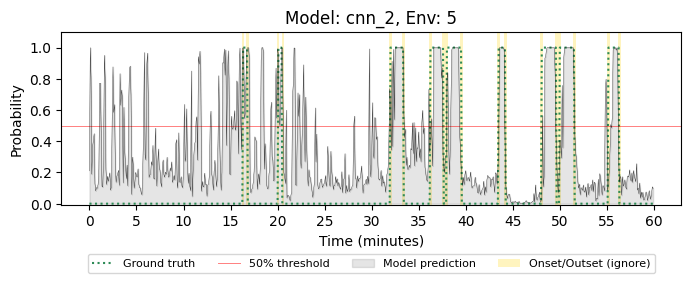

In [17]:
plot_env_predictions(short_model_name='cnn_2', env_n=5)

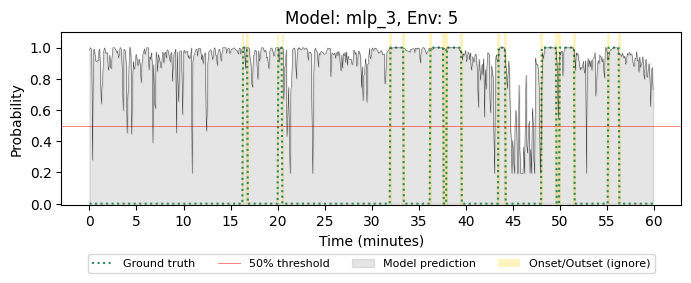

In [18]:
plot_env_predictions(short_model_name='mlp_3', env_n=5)